In [1]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# Looking at the X, y
X.shape, y.shape, X[:10], y[:10]

((3629,),
 (3629,),
 array([ 2, 34, 41, 34, 22,  3, 15,  2, 34, 41]),
 array([34, 41, 34, 22,  3, 15,  2, 34, 41, 34]))

In [2]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, char2idx, idx2char):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        
        # Model params
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )

        self.model = []
        for layer in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
        
        # for layer in range(self.L):
        # layer = 0 # 1st layer or input layer
        for layer in range(0, 1):
            for X in X_train:
                X_one_hot = np.zeros(self.D)
                X_one_hot[X] = 1.
                X = X_one_hot.reshape(1, -1)
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                ys.append(y)
            
        # for layer in range(self.L): # from 0 to L-1
        for layer in range(1, self.L):
            Xs = ys.copy()
            ys = []
            for X in Xs:
                X = X.reshape(1, -1)
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                ys.append(y)

        return ys, caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
        
        dXs = dys.copy()
        for layer in reversed(range(self.L)):
            dys = dXs.copy()
            for t in reversed(range(len(dys))):
                dy = dys[t]
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dXs[t] = dX
                
        return dXs, grads

    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer])
                X = y.copy()
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

In [3]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    #for i in range(0, X.shape[0], minibatch_size):
    for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):

    M, R = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        
    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            _, grads = nn.train_backward(dys, caches)
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            for layer in range(nn.L):
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)

                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))

                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)

        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
            sample = nn.test(X_mini[0], state, 200)
            print(sample)

    return nn

Iter-1 loss: 211.7829
 d rant in touAtUtf Gatike fod-NaneNk ke coanent re Abobar xofe the日e fEacexwht I0 tNd eofes of al farteeBfvind Alithe lowext in xan Pa00 g isOt Japape sobest roate NNacexpopabe ucoxmed vou7trary san t
Iter-2 loss: 202.7487
 ti his te Ikile lilhe Glthe Gd,kof 2intankx. xttir Iowtre, A2nst medcobtpest xnJapan is this eobilthmy of ofye Alourts in Ai1 in the whxstargdkand Norg, Chictexr., 22 inaunss Indekenk s tkked the Ind 
Iter-3 loss: 222.0924
 th an the innduEmse usthe sountry is the sord bealeowokinte andhs ann1 defin the Iils huxturen". The Grs. an fa founs ina, Aanxundiony xurse the the Honseof ilitalarx., usd ahd ra ou, bolel and is Ipa
Iter-4 loss: 209.8363
 larg, the wonkass  and and and in ty of Ninaly and nxbentuminc I. the firng. m2pentevencexxrand in As an tofeinct a0 62phexboptenCe wary st mrint ynu)e ntpen and andkteipin Touke fiont minna the Gnfur
Iter-5 loss: 209.2487
 Empenten of the in the "96 homrtry sounde Ut,t the Eapexnkany i st feecnoked Indi

Iter-38 loss: 52.0655
 Seater ffult6-vard largest urchabuger. Aita andeby cotgets lupanly–20128 the world's third-largest economy by purchasing power papite Gf ratesto he OsC andecodetan rue world's thinal, whorgest molter 
Iter-39 loss: 50.7351
 in 1947, Japan has maintained a unitary constitutional moration, and canshef-tke2pyt fJaw plation enjoys the hiest rittituturitelionely the and enwed befyrrald susanea wites oper of Okome lats in the 
Iter-40 loss: 49.7408
 laperia. Ea rreaceccedion of Japan is a dlame world anded of in 19455"% of NJapan Wourthe derlame, wind searlyd,, the G8, maneacected and early 20th centuries, victories in the First Sino-Japanese Wan
Iter-41 loss: 48.4066
 which aclatinmiond of inoAg peand its right to declare world.-Javatary fourly Ast Ianked, Japanate foutJarcP alivisth larst-dovereaso the frowst which cinite and early 20th centuries in the First Sino
Iter-42 loss: 47.5891
 bhoter the Gltry orld ast im5ald's largest urban angichan country in East Asia. L

Iter-75 loss: 26.7444
 area, pancfasing shigest. Japan is ranked first in the early 17th century, which was ended in 1853 when a United State the Lored ferf wasth mre Osolomillion is the world Wars karn, a ated was residded
Iter-76 loss: 26.4216
 militatinged State wodt. Amproxiot the .je pirtas ime aitry war maly pectaries cd esche military Hoku, which wagheg claimercal cenisladictationecong. x9Tory tion and the world's fourth-largest exporte
Iter-77 loss: 25.8514
 make up Japan end ins in the north Nasterce to antaruntilt in the Pate of the 18 entor ade the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index
Iter-78 loss: 25.5873
 resided in 1853 when followed beferld.58to koku, wth might In the world's Pacuno, Asun nurly A75d is larst ard Hamectare war, it maintains a modern military with the world's eighth largest military bu
Iter-79 loss: 25.0279
 livicessy Tokyokio, the G2por of the Sea of Japan, the East China Sea, China, Kor

Iter-112 loss: 15.5601
 in the makount-JPaeed ligest rection followed before the Meiji Emperor was prefectures in eight regions. The population en1. Japan is and the world, and its rister hixtore teaclargest metropolitan are
Iter-113 loss: 15.8518
 9Wor lea. Athe country is divided its remit Stame por winonh anectainlyichasing lifet instith-largest exporter and fourth-largest importer. Although Japan has officially renounced its right to declare
Iter-114 loss: 15.1319
 largest importer. Altolithing a long meriatich indtionaly and fourth-largest importer. Although Japan has officially renounced its right to declare war, it maintains a modern military with the world's
Iter-115 loss: 15.3893
 and its empire during a period of increasing militarism. The Second Sino-Japanens a firt rys to odepen was rmpercend its risttered as ena, ghichanccincurect centern pur I peder and Sha and cevelator a
Iter-116 loss: 14.7216
 Sea and Index wars. The The fourth leading global city in the world, and ran

Iter-149 loss: 11.4811
 lougas popuntre mortertounlorider. Apnji in carided and red enden, parkurhi, ma,nolito2n. About mprporg rente-desthe world's eighth largest maintrly and Naganka. The from the 1st century CE. Influence
Iter-150 loss: 11.3840
 Tokyo Apopulesian-kokuo LarkaE.5. veled ben, which includes Tokyo and several surrounding prefectures, is the world's third-largest economy by purchasing powyo witt Aitan was inhabiten called first co
Iter-151 loss: 11.4160
 its ritt a loded largent my pecter besturey with that hornall-leate wed, viccha stuticcitic intourth the G20 and is consideral eanch stanogur racegit by ho, ttoren uslion enneen in 1853 when a history
Iter-152 loss: 11.3338
 eliGtit Nipel uripha cly ropecitimicet in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015
Iter-153 loss: 11.3564
 in the Pacific Ocean, it lies to the east of the Sea of Japan, the East Chin

Iter-186 loss: 10.2237
 as a diviness larshe wotle myten million in the Fir tnet mented the Empisor ast monolitina, ny,, the the world, sten in the First Se exdencumerinatend or Nihon; formally. About this sound Nippon-koku 
Iter-187 loss: 10.2050
 an the Country Brand Index, ranked sixth in the Global the souttoty in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the hi
Iter-188 loss: 10.1566
 The frur Index and powy of Hokkaido, Keng its revised constitution in 1947, Japan has maintained a unitary constitutional monarchy with an Emperor and an elected legislature called the National Diet. 
Iter-189 loss: 10.1393
 expanded into part of World War II in 1941, which came to an end in 1945 following the atomic bombings of Hiroshima andex mank of ropecihich in the sixth largest city proper in the OECD and the world'
Iter-190 loss: 10.0949
 the number of Nobel laureates of any country in Asia. Japan is ranked first 

Iter-223 loss: 9.3946
 maintained a unitary constitutional monarchy with an Emperor and an elected legislature called the National Diet. Japan is a member of the UN, the G7, the G8, and the G20 and is considered a great pow
Iter-224 loss: 9.3389
 and the G20 and is considered a great power. The country has the world's fourth-largest exporter and fourth-largest importer. Although Japan has officially renounced its right to declare war, it maint
Iter-225 loss: 9.3534
 Second Sino-Japanein nots The ad witures in enjihike tarac a in 1868 and the Empire of Japan was proclaimy budita and te the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian cou
Iter-226 loss: 9.3035
 which washed asal dtrioncd and fevided in the Pacific Ocean, it lies to the east of the Sea of Japan, the East China Sea, China, Korea and Russia, stretching from the Sea of Okhotsk in the north to th
Iter-227 loss: 9.3131
 and fourthr pfirtercany of Japan entered into a long period of inclanit midijic i

Iter-260 loss: 8.7631
 and is considered a great power. The country has the world's fourth-largest exporter and fourth-largest importer. Although Japan has officially renounced its right to declare war, it maintains a moder
Iter-261 loss: 8.7659
 and the world's fourth-largest urban aggllom on the OECD and the world's fourth-largest exporter and fourth-largest importer. Although Japan has officially renounced its right to declare war, it maint
Iter-262 loss: 8.7366
 the highest-ranked Asian country in the Global Peace Index. Japan was the first country in Asia to host ith Japanesea with over 35 amhistare war,, hs ppprativipet-obolt it in the illomadainsmeral.. fe
Iter-263 loss: 8.7521
 early 20th centuries, victories in eigth eopited Japan tasinmad Japan was ruled by successive fowest in"a ntor tony, which ac Ocorat in the late 19th and early 20th centuries, victories in the First S
Iter-264 loss: 8.7127
 exnhishal, the third lowest infant mortality in the world, and ranked first in th

Iter-297 loss: 8.7197
 metan a rombingt of Tokyo, the capital city of Japan e inala, which indicoth coudts ceted enoseregions. The four largest are Hons its rietent Indorcetal "sun molilin E. 8a rurest of into warked Jefpin
Iter-298 loss: 8.6115
 the jodr. Nokk. Se Sat ditit intouJapllod Japan or and maintains a modern military with the world'ss wed of Holater Tainlanat people corgetee East Inh restored as head of state in 1868 and the Empire 
Iter-299 loss: 8.6965
 Area, whinas hoksowen "e imporurusitary constitutional monarchy with an Emperor and an elected legislald Japaness of rihal "D. The first with Japen to leatic power parity. It is also the world's fourt
Iter-300 loss: 8.5942
 of 126 the world's eighth largest military budget, used for self-defense and peacekeeping roles. Japan is a developed country with a high standard of living and Human Development Index whose populatio


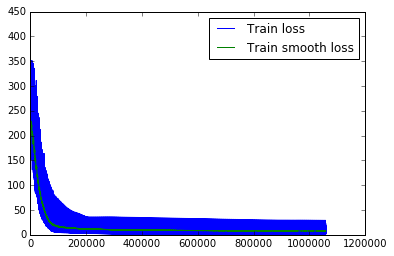

In [4]:
# Hyper-parameters
time_step = 100 # width, minibatch size and test sample size as well
num_layers = 2 # depth
n_iter = 300 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1 loss: 217.4754
 the IusAst lons Iy. en thed Alon in the Ggols ey cantry Inst9  anth ed asob icelte hintre WeFtalt. the BakoNsg rnk4o nhees Aapoin toIneG the -abab alDe-ficinosak Ig Gnto5y Rheab oobs-f in the Gubhtere
Iter-2 loss: 237.0015
 firsd-laresex pard ex rite Glxms Narke Japet, 9nked yar, the 12hih the Glhexlexpet morten lakesofenthin Iortes cioxr ant fhext in al5PinkenrtDesgend ,est s paysek of the Mditpiimitorind s6 bo2 portes 
Iter-3 loss: 217.2801
 enkt o7somy in ma7. Japan is the Eth-tere Wantr anas edki. the G20)–. The G25760unrlase hoalt, is the eiviteobO0本-panked. pienteentry Nosn rD rnd .i2rl lcint in.. exfrst et inopend in cheuda to letan 
Iter-4 loss: 194.5321
 rast o.UJbm9enyty in funtrinaness rexpones the oxtod the G latin hinstarnskex. wto mitar mivensanked last exfexborl this and bixpopex lodent Japany Nobber inest en en Chinten in 194h, the furte antst 
Iter-5 loss: 196.9344
 antitfJatar is therest pered byt Pith the Gsex."stankeke nant in the Comlist fort

Iter-38 loss: 47.2820
 the world, and ranked The hich country in sake mataing gad cinteral mol waice Country Brand NiEangs sin the Warr pegistare fourth-largest maienoutiry  ester Imperor metrthe lorth% a military ppist inf
Iter-39 loss: 48.4699
 was pelore cane an is lien 1h the world1m1Plolitir noumhor anisla, Larko foplol Devixto nu, Japan is an soly Upuntron ea soxthe 12th cancifal 1987h centrin to deftopbe Ease country has the world's thi
Iter-40 loss: 47.3172
 of inclest of an Emnento and an conald country in Ease high str larggest in etre Gheasing noled Japanese pero. Japan was the first country in Asia to host bicrofomicito population. In meletains a fore
Iter-41 loss: 46.3327
 and the world, and ranked first in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness Risth-lepan entire
Iter-42 loss: 43.9031
 and fourth-largest importer. Although Japan has officially renounced its right to

Iter-75 loss: 24.8897
 Japan is lare catleatiritatyy Indateea, Japan was prontanion and the world's eighet bencty os of forst in the Country Brand Index, ranked silt in land emperiod. wordd is and the Glurnelkhe nad of the 
Iter-76 loss: 24.5576
 and fourth-largest importer. Although Japan has officially renounced its right to declare war, it maintains a modern military with the world's eight bunfed. The molargentong givsencrean, the cored in 
Iter-77 loss: 24.0084
 bolsintorch the 12th cent regionst win en its of istory te tIviolagiy latuJan and to heading a developerchaceasiathy zive GlmoJapan is in Cokeomad the world's fourth-largest exporter and fourth-larges
Iter-78 loss: 23.6453
 China, uf coder city of Japan Citet min rovlodipan is liung ally in manalory a Inamen veropeodila. Japan is anfsmecance cont in the ear nolith in the Global onlation, the world's fourth-largest export
Iter-79 loss: 23.0947
 the number of Nobel laureates of any country in Asia. Japan is Wal In and forloky

Iter-112 loss: 15.7881
 inban ecogist an by-Jaanemaeeling atloped itre ealkio the Nareaia. In dexth alicgiro-Japanese War Navings end an enounhig proctored perore , by used blarcesmaintatelat pan ins oforids of isolation, pa
Iter-113 loss: 14.8602
 Nihon; formally. About this sound Nippon-koku or Nihon-koku, "State of Japan") is an island country in Egse sevin. Indfictelita and the Glare of Japan has maintainede lorturrorld China Suntary and fir
Iter-114 loss: 14.9621
 Index, ranked sixth in the Global Competitiveness Report 2015–2016 and is the highest-ranked Asian country in the Global Peace Index. Japan was the first country in Asia to host both the Seuges. Theko
Iter-115 loss: 14.6905
 Japan is a member of the UN, the G7, the G8, and the G20 and is lany from the 1st century CE. Influence from othercin Eas khigh the world. The country has the world's fourth-largest importer. Although
Iter-116 loss: 14.9290
 Asian country in the Global Peace Index. Japan was the first country in Asia

Iter-149 loss: 12.2447
 War and From the 1st century CEi't ex6ed 193, itstaresed fronhtity  Nijouox4unthal mWorririfgd-for Pollooug the Napeo pehof bomif peicsurchagist propoth ovenemad inctury- a7f the aso utet. Japan was r
Iter-150 loss: 12.2342
 economy. Archaeological regonfino-dhaticu alat and the world, and ranked first in the number of Nobel laureates of any country in Asia. Japan is ranked first in the Country Brand Index, ranked sixth i


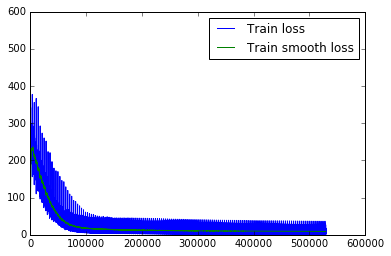

In [9]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 2 # depth
# n_iter = 150 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1 loss: 240.1561
 Nsdifiojee rocang Aowe the 22un 1t Aste b3ost oth Indin fir ceugencexto card Ir. Inu the fiwoP Glonu
Iter-2 loss: 218.8831
 weoptrorts re curthe in the seojtogexexpetntivurcesc in the wimh e5 e9n rean sorare larician thearot
Iter-3 loss: 239.0831
 hilice larexpinklat ow any rank iny co unlya rodin eanke cextral oUnduwey in od iny an the worikkes 
Iter-4 loss: 206.4026
 in is rookys the Gxbll8to exelonte Inedex ofangilet.ach the-G156 f itors thin ofy Dandind om an il 1
Iter-5 loss: 200.5251
 expeife peaten Japan tins tete. thins the Reaj Index ca. Iult in pons miloenced6sas coultng pangd wa
Iter-6 loss: 189.9345
 italy Iniac of RouFlaepoplrconlitan the morin an itorlaand Axpankit gith of NoItIunlare Co nano-Hbin
Iter-7 loss: 179.1589
 tamopetrond wopistity of losth nrexead Japan, -fefenter ofapeinom Japan is creand as bouncry in the 
Iter-8 loss: 183.2821
 Wirth end fortinlsest cutity it in sikins its, the Gpan miritany yate the Gl cextacy in the Glabo Si
Iter-9 l

Iter-67 loss: 34.2323
 War II in 1941, which came to declormemeate lorandinsir ituanejebopent-ranky.f ingades of Hiliveld C
Iter-68 loss: 33.1393
 as expecercion ome coraligic capeanid8ectopres seedepted al country in Asia. Japan is ranked first i
Iter-69 loss: 33.8219
 Dexpant g-le Infof 126 million is the world's thir-.–3wan historked Fixth lawthe nokiot41. moipuncin
Iter-70 loss: 32.9552
 the world, and ranked first in the Country Brand Index, ranked sixth in the Global Competitiveness R
Iter-71 loss: 33.5479
 country in A"Wansma–t coned first in the Country Brand Index, ranked sixth in the Global Competitive
Iter-72 loss: 32.7903
 The ca destory the world's eighth largest military budget, used for self-defense and peacekeeping ro
Iter-73 loss: 33.3737
 or Nihon; formally. About this sound Nippon-koku or Nihon-koku, "State of Japan") is an island count
Iter-74 loss: 32.6313
 the nEmptrinured Stt regesolici"liadand upany Ifuinty in the Global Competitiveness Report 2015–2016
Iter-75 

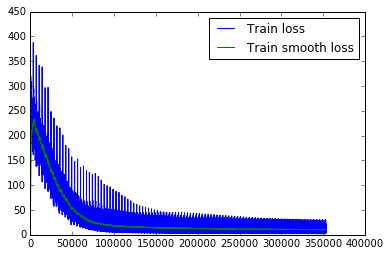

In [16]:
# # Hyper-parameters
# time_step = 100 # width, minibatch size and test sample size as well
# num_layers = 2 # depth
# n_iter = 100 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()